### Overview
This notebook is the continuation of pevious notebook Value_at_Risk(1). In the previous notebook, different methods are introduced for calculating 1-day VaR. Although one may estimate K-day VaR by multiplying sqrt(K) with 1-day VaR, another method for calculating K-day VaR is by Monte Carlo Simulation. The techniques of Monte Carlo Simulation for calculating the VaR value is demostrated in this notebook. 

##### Note: VaR is treated as negative value in this notebook (although it is defined as positive number by convention)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime
from scipy.stats import norm

### Data

The Hang Seng Index(HSI) data from year 2010 to 2021 are used in this notebook. The data are obtained from Yahoo Finance.

In [2]:
df_hsi = pd.read_csv('HSI_2010_2021.csv')
df_hsi['Date'] = pd.to_datetime(df_hsi['Date'], format='%Y-%m-%d')
df_hsi.dropna(inplace=True)
df_hsi

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,21860.039063,22024.830078,21689.220703,21823.279297,21823.279297,1.006200e+09
1,2010-01-05,22092.150391,22297.039063,21987.269531,22279.580078,22279.580078,1.965585e+09
2,2010-01-06,22357.460938,22514.789063,22277.130859,22416.669922,22416.669922,2.100234e+09
3,2010-01-07,22548.029297,22548.029297,22169.609375,22269.449219,22269.449219,1.495365e+09
4,2010-01-08,22282.750000,22443.220703,22206.160156,22296.750000,22296.750000,1.626023e+09
...,...,...,...,...,...,...,...
2957,2021-12-23,23141.789063,23264.750000,23027.150391,23193.640625,23193.640625,1.387904e+09
2958,2021-12-24,23375.990234,23383.189453,23186.570313,23223.759766,23223.759766,6.228797e+08
2959,2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,1.433027e+09
2960,2021-12-29,23253.980469,23253.980469,23008.279297,23086.539063,23086.539063,8.284144e+08


### Monte Carlo Simulation (MC)
The idea of Monte Carlo Simiulation is to generate artificial returns with the help of random number drawn from a specified distribution. This process is repeated for many times so that a large amount of artificial returns is genereated. The 100p% VaR is obtained from the 100p-percentile of the artificial returns. 

The methods mentioned in the notebook VaR_at_Risk(1) mainly focus on one-day-ahead distribution modeling to calculate 1-day VaR. On the other hand, Monte Carlo simulation is able to model the multiday distribution to calculate K-day VaR.

The first problem we need to solve is to find an appropriate model to simulate the daily return. A popular model is to assume that the daily return follows a normal distribution with contant mean, and the daily variance is estimated by GARCH(1,1) model. 

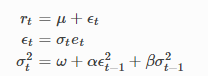

We can simulate the return of the stock over K days and calculate total return at the end of period. Then we repeat this process for N times (e.g. 10000 times) so that we can get a series of simulated period returns. Finally, the K-day VaR value can be obtained by calculating the 100p-percentile of the simulated period returns.

In [3]:
def MC_Simulation(df, K, N, p=0.01, GARCH_trained = None, return_hist = False):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'. All data will be used to train GARCH model
    K: int 
        To calculate K-day VaR
    N: int
        Repeat the process for N times
    p: float
        To calculate 100p% VaR
    GARCH_trained: arch.arch_model.fit object
        A trained GARCH model
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_MC' specifying VaR of return 
    '''
    # Training GARCH Model
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace=True)
    ret = df.set_index('Date')['Return']
    if GARCH_trained == None:
        model = arch.arch_model(ret, rescale=False)
        res = model.fit(last_obs=ret.index[-1]) # use all data to fit the model
    else:
        res = GARCH_trained
    # Calculating the estimated Variance 
    forecasts = res.forecast(horizon=5, start=ret.index[-1], reindex=False) 
    tmr_variance = forecasts.variance['h.1'].reset_index() # one day ahead estimation for variance
    original_lastest_variance = tmr_variance.iloc[-1,1] # estimated variance on next day of last date in x
    # Run Monte Carlo Simulation
    mu, omega, alpha, beta = res.params.values # obtain the parameters of GARCH(1,1) model
    returns = []
    hist = []
    for i in range(N):
        r_sum = 0 # record K-period return
        tmp_hist = [0]
        lastest_variance = original_lastest_variance
        for j in range(K):
            z = np.random.normal(0,1)
            r = lastest_variance**0.5 * z
            lastest_variance = omega + alpha * r**2 + beta * lastest_variance  # estimate tomorrow's variance
            r_sum += r+mu
            tmp_hist.append(r_sum)
        returns.append(r_sum)
        hist.append(tmp_hist)
    if return_hist:
        return np.quantile(returns, p), hist
    return np.quantile(returns, p)
    

Below is simulation of returns over 10 days. The simulation is run for 50 times to visualize the sample artificial returns.

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15946103119.822626
Iteration:      2,   Func. Count:     19,   Neg. LLF: 229220707296140.84
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1017759683957.9215
Iteration:      4,   Func. Count:     48,   Neg. LLF: 61069645057210.31
Iteration:      5,   Func. Count:     63,   Neg. LLF: 44864615.579924606
Iteration:      6,   Func. Count:     76,   Neg. LLF: 7620551611359.705
Iteration:      7,   Func. Count:     91,   Neg. LLF: 2.453882426037723e+18
Iteration:      8,   Func. Count:    104,   Neg. LLF: 9722606486491.03
Iteration:      9,   Func. Count:    119,   Neg. LLF: 3.3684467924808755e+18
Iteration:     10,   Func. Count:    132,   Neg. LLF: 23152643265971.305
Iteration:     11,   Func. Count:    147,   Neg. LLF: 180807249.2216753
Iteration:     12,   Func. Count:    159,   Neg. LLF: -9088.396662742234
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9088.39666867253
            It

Text(0.5, 1.0, 'Monte Carlo Simulation')

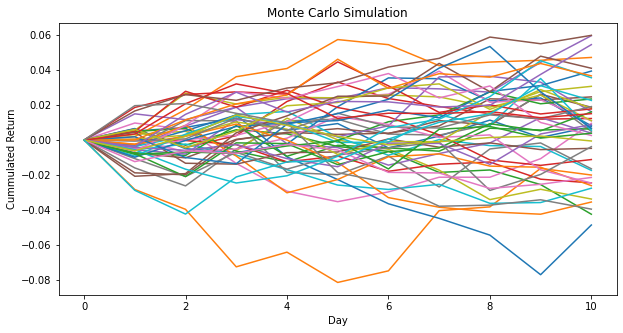

In [4]:
# Plot some artificial returns
df_MC = df_hsi.copy(deep=True)
df_MC['Return'] = np.log(df_MC['Close']/df_MC['Close'].shift(1))
df_MC.dropna(inplace=True)
ret_MC = df_MC.set_index('Date')['Return'] 
model_MC = arch.arch_model(ret_MC, rescale=False)
res_MC = model_MC.fit(last_obs=ret_MC.index[-1]) # use all data to fit the model

K = 10  # calculate 10-day VaR
N = 50  # run the simulation for 50 times
var, hist = MC_Simulation(df_MC, K, N, p=0.01, GARCH_trained = res_MC, return_hist = True)
fig, ax = plt.subplots(figsize=(10,5))
x_axis = list(range(K+1))
for i in hist:
    ax.plot(x_axis, i)
plt.xlabel('Day')
plt.ylabel('Cummulated Return')
plt.title('Monte Carlo Simulation')

By using all the data to train the GARCH model, let's estimate the K-day 1% VaR of return of HSI for different value of K. 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15946103119.822626
Iteration:      2,   Func. Count:     19,   Neg. LLF: 229220707296140.84
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1017759683957.9215
Iteration:      4,   Func. Count:     48,   Neg. LLF: 61069645057210.31
Iteration:      5,   Func. Count:     63,   Neg. LLF: 44864615.579924606
Iteration:      6,   Func. Count:     76,   Neg. LLF: 7620551611359.705
Iteration:      7,   Func. Count:     91,   Neg. LLF: 2.453882426037723e+18
Iteration:      8,   Func. Count:    104,   Neg. LLF: 9722606486491.03
Iteration:      9,   Func. Count:    119,   Neg. LLF: 3.3684467924808755e+18
Iteration:     10,   Func. Count:    132,   Neg. LLF: 23152643265971.305
Iteration:     11,   Func. Count:    147,   Neg. LLF: 180807249.2216753
Iteration:     12,   Func. Count:    159,   Neg. LLF: -9088.396662742234
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9088.39666867253
            It

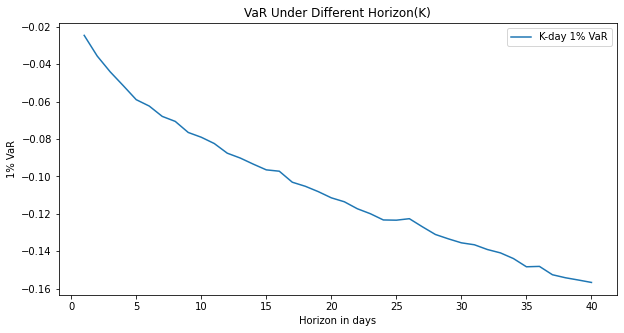

In [5]:
# Visulaize the K-day 1% VaR for different value of K
df_MC = df_hsi.copy(deep=True)
df_MC['Return'] = np.log(df_MC['Close']/df_MC['Close'].shift(1))
df_MC.dropna(inplace=True)
ret_MC = df_MC.set_index('Date')['Return'] 
model_MC = arch.arch_model(ret_MC, rescale=False)
res_MC = model_MC.fit(last_obs=ret_MC.index[-1]) # use all data to fit the model
var_MC = []
max_K = 40
p = 0.01
N = 10000  # number of simulation
_, hist = MC_Simulation(df_MC, max_K, N, p, GARCH_trained = res_MC, return_hist = True)
hist = np.array(hist)
for i in range(1, max_K+1):
    var_MC.append(np.quantile(hist[:,i], p))
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(list(range(1,max_K+1)), var_MC, label='K-day 1% VaR')
plt.xlabel("Horizon in days")
plt.ylabel("1% VaR")
plt.title('VaR Under Different Horizon(K)')
plt.legend()

The figure shows that the VaR of return decreases with horizon in days, which makes sense because the variance of period return should increase with length of period. Hence, greater loss is more possible when the trading period is longer. 

### Filtered Historical Simulation with Monte Carlo Simulation (FHS_MC)

The previous MC simulation assumes that the daily return follow a normal distribution when modeling the daily return, which may not be realistic. Therefore, filtered historical simulation is designed to handle this problem. Instead of drawing random samples from normal distribution to calculate the artificial return, we draw the random samples from standardized returns, which are calculated by dividing historical daily returns with standard deviation on the same day. Then the remaining calculations are the same as the previoud method.

In [6]:
def FHS_MC_Simulation(df, K, N, p=0.01, GARCH_trained = None, return_hist = False):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'. All data will be used to train GARCH model
    K: int 
        To calculate K-day VaR
    N: int
        Repeat the process for N times
    p: float
        To calculate 100p% VaR
    GARCH_trained: arch.arch_model.fit object
        A trained GARCH model
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_MC' specifying VaR of return 
    '''
    # Training GARCH Model
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace=True)
    ret = df.set_index('Date')['Return']
    if GARCH_trained == None:
        model = arch.arch_model(ret, rescale=False)
        res = model.fit(last_obs=ret.index[-1]) # use all data to fit the model
    else:
        res = GARCH_trained
    # Calculating standardized returns
    forecasts = res.forecast(horizon=5, start=ret.index[0], reindex=False) 
    tmr_variance = forecasts.variance['h.1'].reset_index() # one day ahead estimation for variance
    original_lastest_variance = tmr_variance.iloc[-1,1] # estimated variance on next day of last date in x
    tmr_variance.rename(columns={'h.1':'tmr_variance'}, inplace=True)
    df = pd.merge(df, tmr_variance, on='Date')
    df['tdy_sd'] = np.sqrt(df['tmr_variance'].shift(1))
    df['standardized_return'] = df['Return']/df['tdy_sd']
    df.dropna(inplace=True)
    # Run Monte Carlo Simulation
    mu, omega, alpha, beta = res.params.values
    returns = []
    hist = []
    for i in range(N):
        r_sum = 0
        hist_tmp = [0]
        lastest_variance = original_lastest_variance
        for j in range(K):
            z = np.random.choice(df['standardized_return'])
            r = lastest_variance**0.5 * z
            lastest_variance = omega + alpha * r**2 + beta * lastest_variance
            r_sum += r+mu
            hist_tmp.append(r_sum)
        returns.append(r_sum)
        hist.append(hist_tmp)
    if return_hist:
        return np.quantile(returns, p), hist
    return np.quantile(returns, p)

Below is simulation of returns over 10 days. The simulation is run for 50 times to visualize the sample artificial returns.

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15946103119.822626
Iteration:      2,   Func. Count:     19,   Neg. LLF: 229220707296140.84
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1017759683957.9215
Iteration:      4,   Func. Count:     48,   Neg. LLF: 61069645057210.31
Iteration:      5,   Func. Count:     63,   Neg. LLF: 44864615.579924606
Iteration:      6,   Func. Count:     76,   Neg. LLF: 7620551611359.705
Iteration:      7,   Func. Count:     91,   Neg. LLF: 2.453882426037723e+18
Iteration:      8,   Func. Count:    104,   Neg. LLF: 9722606486491.03
Iteration:      9,   Func. Count:    119,   Neg. LLF: 3.3684467924808755e+18
Iteration:     10,   Func. Count:    132,   Neg. LLF: 23152643265971.305
Iteration:     11,   Func. Count:    147,   Neg. LLF: 180807249.2216753
Iteration:     12,   Func. Count:    159,   Neg. LLF: -9088.396662742234
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9088.39666867253
            It

Text(0.5, 1.0, 'Monte Carlo Simulation')

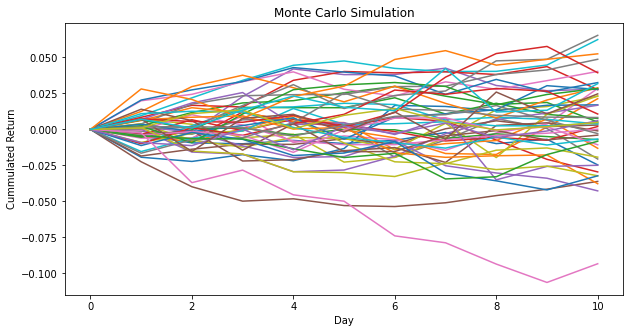

In [7]:
# Plot some artificial returns
df_FHS_MC = df_hsi.copy(deep=True)
df_FHS_MC['Return'] = np.log(df_FHS_MC['Close']/df_FHS_MC['Close'].shift(1))
df_FHS_MC.dropna(inplace=True)
ret_FHS_MC = df_FHS_MC.set_index('Date')['Return'] 
model_FHS_MC = arch.arch_model(ret_FHS_MC, rescale=False)
res_FHS_MC = model_FHS_MC.fit(last_obs=ret_FHS_MC.index[-1]) # use all data to fit the model

K = 10  # calculate 10-day VaR
N = 50  # run the simulation for 50 times
var, hist = FHS_MC_Simulation(df_FHS_MC, K, N, p=0.01, GARCH_trained = res_FHS_MC, return_hist = True)
fig, ax = plt.subplots(figsize=(10,5))
x_axis = list(range(K+1))
for i in hist:
    ax.plot(x_axis, i)
plt.xlabel('Day')
plt.ylabel('Cummulated Return')
plt.title('Monte Carlo Simulation')

By using all the data to train the GARCH model, let's estimate the K-day 1% VaR of return of HSI for different value of K. 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15946103119.822626
Iteration:      2,   Func. Count:     19,   Neg. LLF: 229220707296140.84
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1017759683957.9215
Iteration:      4,   Func. Count:     48,   Neg. LLF: 61069645057210.31
Iteration:      5,   Func. Count:     63,   Neg. LLF: 44864615.579924606
Iteration:      6,   Func. Count:     76,   Neg. LLF: 7620551611359.705
Iteration:      7,   Func. Count:     91,   Neg. LLF: 2.453882426037723e+18
Iteration:      8,   Func. Count:    104,   Neg. LLF: 9722606486491.03
Iteration:      9,   Func. Count:    119,   Neg. LLF: 3.3684467924808755e+18
Iteration:     10,   Func. Count:    132,   Neg. LLF: 23152643265971.305
Iteration:     11,   Func. Count:    147,   Neg. LLF: 180807249.2216753
Iteration:     12,   Func. Count:    159,   Neg. LLF: -9088.396662742234
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9088.39666867253
            It

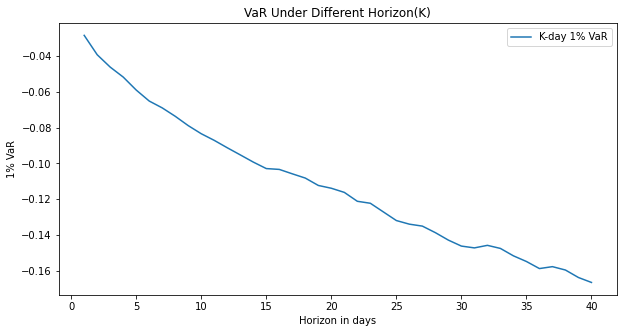

In [8]:
# Visulaize the K-day 1% VaR for different value of K
df_FHS_MC = df_hsi.copy(deep=True)
df_FHS_MC['Return'] = np.log(df_FHS_MC['Close']/df_FHS_MC['Close'].shift(1))
df_FHS_MC.dropna(inplace=True)
ret_FHS_MC = df_FHS_MC.set_index('Date')['Return'] 
model_FHS_MC = arch.arch_model(ret_FHS_MC, rescale=False)
res_FHS_MC = model_FHS_MC.fit(last_obs=ret_FHS_MC.index[-1]) # use all data to fit the model
var_FHS_MC = []
max_K = 40
p = 0.01
N = 10000  # number of simulation
_, hist = FHS_MC_Simulation(df_FHS_MC, max_K, N, p, GARCH_trained = res_FHS_MC, return_hist = True)
hist = np.array(hist)
for i in range(1, max_K+1):
    var_FHS_MC.append(np.quantile(hist[:,i], p))
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(list(range(1,max_K+1)), var_FHS_MC, label='K-day 1% VaR')
plt.xlabel("Horizon in days")
plt.ylabel("1% VaR")
plt.title('VaR Under Different Horizon(K)')
plt.legend()

### Comparison of Simple MC and FHS_MC

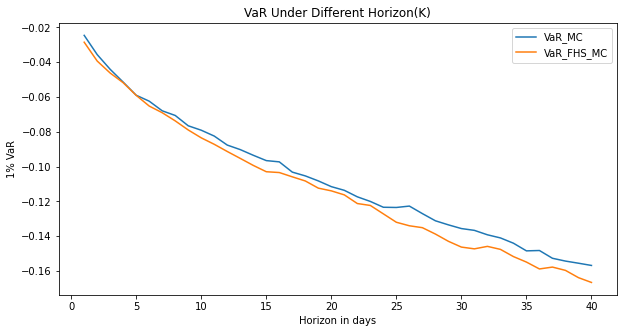

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(list(range(1,max_K+1)), var_MC, label='VaR_MC')
ax.plot(list(range(1,max_K+1)), var_FHS_MC, label='VaR_FHS_MC')
plt.xlabel("Horizon in days")
plt.ylabel("1% VaR")
plt.title('VaR Under Different Horizon(K)')
plt.legend()

From the figure, it seems that FHS_MC tends to produce a lower VaR value than simple MC does. It is because in reality, the distribution of return has a thicker tail than normal distribution. Hence, large loss is more possible when running simmulation with Filtered Historical Simulation. This can explain why FHS_MC produces a lower VaR value than simple MC does.